In [1]:
import os
import sys
import pathlib
import pickle as pkl
import json
import itertools

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from tqdm import tqdm

import fir.utils.time
import fir.utils.dict

from time import time
from datetime import datetime

import pprint

---

# Load experiment data

In [2]:
def load_json_dict(
        json_filename
        ):

    with open(json_filename, 'r') as json_file:
        json_dict = json.load(json_file)

    return json_dict

In [3]:
exp_data_all = {}

In [4]:
exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_train")

backbones = ["resnet_50", "convnext_t"]
num_exps_list = [9, 13]

for backbone, num_exps in zip(backbones, num_exps_list):

    exp_data_all[backbone] = {}
    
    for exp_idx in range(num_exps):

        exp_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "exp_data_corr.json")
        exp_data = load_json_dict(exp_filename)

        exp_data_all[backbone][exp_idx] = exp_data

In [5]:
exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_train_DDP_2")

backbones = ["swint_v2_t"]
num_exps_list = [12]

for backbone, num_exps in zip(backbones, num_exps_list):

    exp_data_all[backbone] = {}
    
    for exp_idx in range(num_exps):

        exp_filename_s1 = os.path.join(exp_dirname, backbone, "run_013", "train_ret_DDP_stage_1__data.json")
        exp_data_s1 = load_json_dict(exp_filename_s1)

        exp_filename_s2 = os.path.join(exp_dirname, backbone + "_s2", "run_{:03d}".format(exp_idx), "train_ret_DDP_stage_2__data.json")
        exp_data_s2 = load_json_dict(exp_filename_s2)

        exp_data_s1["settings"]["stage_2"] = exp_data_s2["settings"]["stage_2"]
        exp_data_s1["results"]["stage_2"] = exp_data_s2["results"]["stage_2"]

        exp_data_all[backbone][exp_idx] = exp_data_s1

---

# Time DataFrame

In [6]:
df_records = []

In [7]:
exp_data_list = []
exp_name_list = []

for exp_idx, exp_data in exp_data_all["resnet_50"].items():
    exp_data_list.append(exp_data)
    exp_name_list.append("test_{:03d}".format(exp_idx))

for exp_idx, exp_data in exp_data_all["convnext_t"].items():
    exp_data_list.append(exp_data)
    exp_name_list.append("test_{:03d}".format(exp_idx))

###

for exp_name, exp_data in zip(exp_name_list, exp_data_list):

    stage_1_train_epoch_time_list = list(map(lambda l: np.max(l), exp_data["results"]["stage_1"]["train_epoch_time_list"]))
    stage_2_train_epoch_time_list = list(map(lambda l: np.max(l), exp_data["results"]["stage_2"]["train_epoch_time_list"]))
    stage_1_val_epoch_time_list = list(map(lambda l: np.max(l), exp_data["results"]["stage_1"]["val_epoch_time_list"]))
    stage_2_val_epoch_time_list = list(map(lambda l: np.max(l), exp_data["results"]["stage_2"]["val_epoch_time_list"]))

    stage_1_epoch_time_list = np.add(stage_1_train_epoch_time_list, stage_1_val_epoch_time_list)
    stage_2_epoch_time_list = np.add(stage_2_train_epoch_time_list, stage_2_val_epoch_time_list)

    df_record = {}

    # Params

    df_record["backbone"] = exp_data["settings"]["backbone"]["class"]
    df_record["experiment_name"] = exp_name

    num_gpus = len(exp_data["settings"]["gpu_usage"])
    df_record["num_gpus"] = num_gpus

    stage_1_batch_size = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    stage_2_batch_size = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
    df_record["stage_1_batch_size"] = stage_1_batch_size
    df_record["stage_2_batch_size"] = stage_2_batch_size

    stage_1_grad_acc_iters = fir.utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
    stage_2_grad_acc_iters = fir.utils.dict.chain_get(exp_data, "settings", "stage_2", "data_loading", "grad_acc_iters", default=1)
    df_record["stage_1_grad_acc_iters"] = stage_1_grad_acc_iters
    df_record["stage_2_grad_acc_iters"] = stage_2_grad_acc_iters

    df_record["stage_1_loading_batch_size"] = stage_1_batch_size * stage_1_grad_acc_iters * num_gpus
    df_record["stage_2_loading_batch_size"] = stage_2_batch_size * stage_2_grad_acc_iters * num_gpus

    df_record["stage_1_base_lr"] = exp_data["settings"]["stage_1"]["base_lr"]
    df_record["stage_2_base_lr"] = exp_data["settings"]["stage_2"]["base_lr"]

    df_record["stage_1_epochs"] = exp_data["results"]["stage_1"]["num_epochs"]
    df_record["stage_2_epochs"] = exp_data["results"]["stage_2"]["num_epochs"]

    # Results

    df_record["stage_1_mean_epoch_time"] = np.mean(stage_1_epoch_time_list)
    df_record["stage_2_mean_epoch_time"] = np.mean(stage_2_epoch_time_list)
    
    df_record["stage_1_mean_epoch_time_corr"] = df_record["stage_1_mean_epoch_time"] * df_record["num_gpus"]
    df_record["stage_2_mean_epoch_time_corr"] = df_record["stage_2_mean_epoch_time"] * df_record["num_gpus"]

    df_record["stage_1_total_epoch_time"] = np.sum(stage_1_epoch_time_list)
    df_record["stage_2_total_epoch_time"] = np.sum(stage_2_epoch_time_list)
    
    df_record["stage_1_total_epoch_time_corr"] = df_record["stage_1_total_epoch_time"] * df_record["num_gpus"]
    df_record["stage_2_total_epoch_time_corr"] = df_record["stage_2_total_epoch_time"] * df_record["num_gpus"]

    df_record["training_time_corr"] = df_record["stage_1_total_epoch_time_corr"] + df_record["stage_2_total_epoch_time_corr"]

    # Time format

    df_record["stage_1_mean_epoch_time_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_1_mean_epoch_time"])
    df_record["stage_2_mean_epoch_time_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_2_mean_epoch_time"])

    df_record["stage_1_mean_epoch_time_corr_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_1_mean_epoch_time_corr"])
    df_record["stage_2_mean_epoch_time_corr_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_2_mean_epoch_time_corr"])

    df_record["stage_1_total_epoch_time_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_1_total_epoch_time"])
    df_record["stage_2_total_epoch_time_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_2_total_epoch_time"])

    df_record["stage_1_total_epoch_time_corr_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_1_total_epoch_time_corr"])
    df_record["stage_2_total_epoch_time_corr_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_2_total_epoch_time_corr"])

    df_record["training_time_corr_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["training_time_corr"])

    df_records.append(df_record)

In [8]:
exp_data_list = []
exp_name_list = []

for exp_idx, exp_data in exp_data_all["swint_v2_t"].items():
    exp_data_list.append(exp_data)
    exp_name_list.append("run_{:03d}".format(exp_idx))

###

for exp_name, exp_data in zip(exp_name_list, exp_data_list):

    stage_1_train_epoch_time_list = list(map(lambda l: np.max(l), exp_data["results"]["stage_1"]["train_epoch_time_list"]))
    stage_1_val_epoch_time_list = list(map(lambda l: np.max(l), exp_data["results"]["stage_1"]["val_epoch_time_list"]))

    stage_1_epoch_time_list = np.add(stage_1_train_epoch_time_list, stage_1_val_epoch_time_list)

    stage_2_train_epoch_time_list = list(map(lambda l: np.max(l), exp_data["results"]["stage_2"]["train_epoch_time_list"]))
    stage_2_val_epoch_time_list = list(map(lambda l: np.max(l), exp_data["results"]["stage_2"]["val_epoch_time_list"]))

    stage_2_epoch_time_list = np.add(stage_2_train_epoch_time_list, stage_2_val_epoch_time_list)

    df_record = {}

    # Params

    df_record["backbone"] = exp_data["settings"]["backbone"]["class"]
    df_record["experiment_name"] = exp_name

    num_gpus = len(exp_data["settings"]["gpu_usage"])
    df_record["num_gpus"] = num_gpus

    stage_1_batch_size = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    df_record["stage_1_batch_size"] = stage_1_batch_size
    stage_2_batch_size = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
    df_record["stage_2_batch_size"] = stage_2_batch_size
    
    stage_1_grad_acc_iters = fir.utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
    df_record["stage_1_grad_acc_iters"] = stage_1_grad_acc_iters
    stage_2_grad_acc_iters = fir.utils.dict.chain_get(exp_data, "settings", "stage_2", "data_loading", "grad_acc_iters", default=1)
    df_record["stage_2_grad_acc_iters"] = stage_2_grad_acc_iters

    df_record["stage_1_loading_batch_size"] = stage_1_batch_size * stage_1_grad_acc_iters * num_gpus
    df_record["stage_2_loading_batch_size"] = stage_2_batch_size * stage_2_grad_acc_iters * num_gpus

    df_record["stage_1_base_lr"] = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    df_record["stage_2_base_lr"] = exp_data["settings"]["stage_2"]["optimizer"]["lr"]

    df_record["stage_1_epochs"] = exp_data["results"]["stage_1"]["num_epochs"]
    df_record["stage_2_epochs"] = exp_data["results"]["stage_2"]["num_epochs"]

    # Results

    df_record["stage_1_mean_epoch_time"] = np.mean(stage_1_epoch_time_list)
    df_record["stage_2_mean_epoch_time"] = np.mean(stage_2_epoch_time_list)
    
    df_record["stage_1_mean_epoch_time_corr"] = df_record["stage_1_mean_epoch_time"] * df_record["num_gpus"]
    df_record["stage_2_mean_epoch_time_corr"] = df_record["stage_2_mean_epoch_time"] * df_record["num_gpus"]

    df_record["stage_1_total_epoch_time"] = np.sum(stage_1_epoch_time_list)
    df_record["stage_2_total_epoch_time"] = np.sum(stage_2_epoch_time_list)
    
    df_record["stage_1_total_epoch_time_corr"] = df_record["stage_1_total_epoch_time"] * df_record["num_gpus"] * 30 / df_record["stage_1_epochs"]
    df_record["stage_2_total_epoch_time_corr"] = df_record["stage_2_total_epoch_time"] * df_record["num_gpus"] * 30 / df_record["stage_2_epochs"]

    # Time format

    df_record["stage_1_mean_epoch_time_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_1_mean_epoch_time"])
    df_record["stage_2_mean_epoch_time_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_2_mean_epoch_time"])

    df_record["stage_1_mean_epoch_time_corr_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_1_mean_epoch_time_corr"])
    df_record["stage_2_mean_epoch_time_corr_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_2_mean_epoch_time_corr"])

    df_record["stage_1_total_epoch_time_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_1_total_epoch_time"])
    df_record["stage_2_total_epoch_time_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_2_total_epoch_time"])

    df_record["stage_1_total_epoch_time_corr_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_1_total_epoch_time_corr"])
    df_record["stage_2_total_epoch_time_corr_format"] = fir.utils.time.sprint_fancy_time_diff(df_record["stage_2_total_epoch_time_corr"])

    df_records.append(df_record)

In [9]:
df = pd.DataFrame.from_records(df_records)

In [10]:
df

,backbone,experiment_name,num_gpus,stage_1_batch_size,stage_2_batch_size,stage_1_grad_acc_iters,stage_2_grad_acc_iters,stage_1_loading_batch_size,stage_2_loading_batch_size,stage_1_base_lr,...,training_time_corr,stage_1_mean_epoch_time_format,stage_2_mean_epoch_time_format,stage_1_mean_epoch_time_corr_format,stage_2_mean_epoch_time_corr_format,stage_1_total_epoch_time_format,stage_2_total_epoch_time_format,stage_1_total_epoch_time_corr_format,stage_2_total_epoch_time_corr_format,training_time_corr_format
0,ResNet50Backbone,test_000,6,32,32,1,1,192,192,2.968750e-05,...,99399.728096,0:03:34.608,0:05:37.612,0:21:27.648,0:33:45.675,1:47:18.244,2:48:48.377,10:43:49.464,16:52:50.263,27:36:39.728
1,ResNet50Backbone,test_001,6,32,32,1,1,192,192,2.968750e-06,...,94061.171036,0:03:03.726,0:05:38.835,0:18:22.359,0:33:53.013,1:31:51.796,2:49:25.065,9:11:10.776,16:56:30.395,26:07:41.171
2,ResNet50Backbone,test_002,6,32,32,1,1,192,192,2.968750e-07,...,95215.591827,0:03:05.181,0:05:43.793,0:18:31.091,0:34:22.761,1:32:35.459,2:51:53.806,9:15:32.755,17:11:22.836,26:26:55.591
3,ResNet50Backbone,test_003,6,16,16,1,1,96,96,5.937500e-05,...,100323.310982,0:03:17.434,0:05:59.917,0:19:44.607,0:35:59.502,1:38:43.037,2:59:57.514,9:52:18.224,17:59:45.086,27:52:03.310
4,ResNet50Backbone,test_004,6,16,16,1,1,96,96,5.937500e-06,...,100327.211128,0:03:16.585,0:06:00.788,0:19:39.511,0:36:04.728,1:38:17.557,3:00:23.644,9:49:45.345,18:02:21.865,27:52:07.211
5,ResNet50Backbone,test_005,6,16,16,1,1,96,96,5.937500e-07,...,101663.820099,0:03:19.491,0:06:05.307,0:19:56.947,0:36:31.846,1:39:44.736,3:02:39.233,9:58:28.421,18:15:55.398,28:14:23.820
6,ResNet50Backbone,test_006,6,8,8,1,1,48,48,1.187500e-04,...,123873.182098,0:04:06.109,0:07:22.074,0:24:36.656,0:44:12.449,2:03:03.282,3:41:02.247,12:18:19.697,22:06:13.484,34:24:33.182
7,ResNet50Backbone,test_007,6,8,8,1,1,48,48,1.187500e-05,...,124010.728638,0:04:05.356,0:07:23.592,0:24:32.137,0:44:21.553,2:02:40.688,3:41:47.766,12:16:04.130,22:10:46.598,34:26:50.728
8,ResNet50Backbone,test_008,6,8,8,1,1,48,48,1.187500e-06,...,124259.237137,0:04:05.787,0:07:24.541,0:24:34.722,0:44:27.251,2:02:53.613,3:42:16.259,12:17:21.681,22:13:37.555,34:30:59.237
9,ConvNeXtTinyBackbone,test_000,4,16,16,1,1,64,64,5.937500e-05,...,325241.797363,0:14:47.506,0:30:22.841,0:59:10.026,2:01:31.367,7:23:45.196,15:11:25.253,29:35:00.784,60:45:41.013,90:20:41.797


In [11]:
df.columns

Index(['backbone', 'experiment_name', 'num_gpus', 'stage_1_batch_size',
       'stage_2_batch_size', 'stage_1_grad_acc_iters',
       'stage_2_grad_acc_iters', 'stage_1_loading_batch_size',
       'stage_2_loading_batch_size', 'stage_1_base_lr', 'stage_2_base_lr',
       'stage_1_epochs', 'stage_2_epochs', 'stage_1_mean_epoch_time',
       'stage_2_mean_epoch_time', 'stage_1_mean_epoch_time_corr',
       'stage_2_mean_epoch_time_corr', 'stage_1_total_epoch_time',
       'stage_2_total_epoch_time', 'stage_1_total_epoch_time_corr',
       'stage_2_total_epoch_time_corr', 'training_time_corr',
       'stage_1_mean_epoch_time_format', 'stage_2_mean_epoch_time_format',
       'stage_1_mean_epoch_time_corr_format',
       'stage_2_mean_epoch_time_corr_format',
       'stage_1_total_epoch_time_format', 'stage_2_total_epoch_time_format',
       'stage_1_total_epoch_time_corr_format',
       'stage_2_total_epoch_time_corr_format', 'training_time_corr_format'],
      dtype='object')

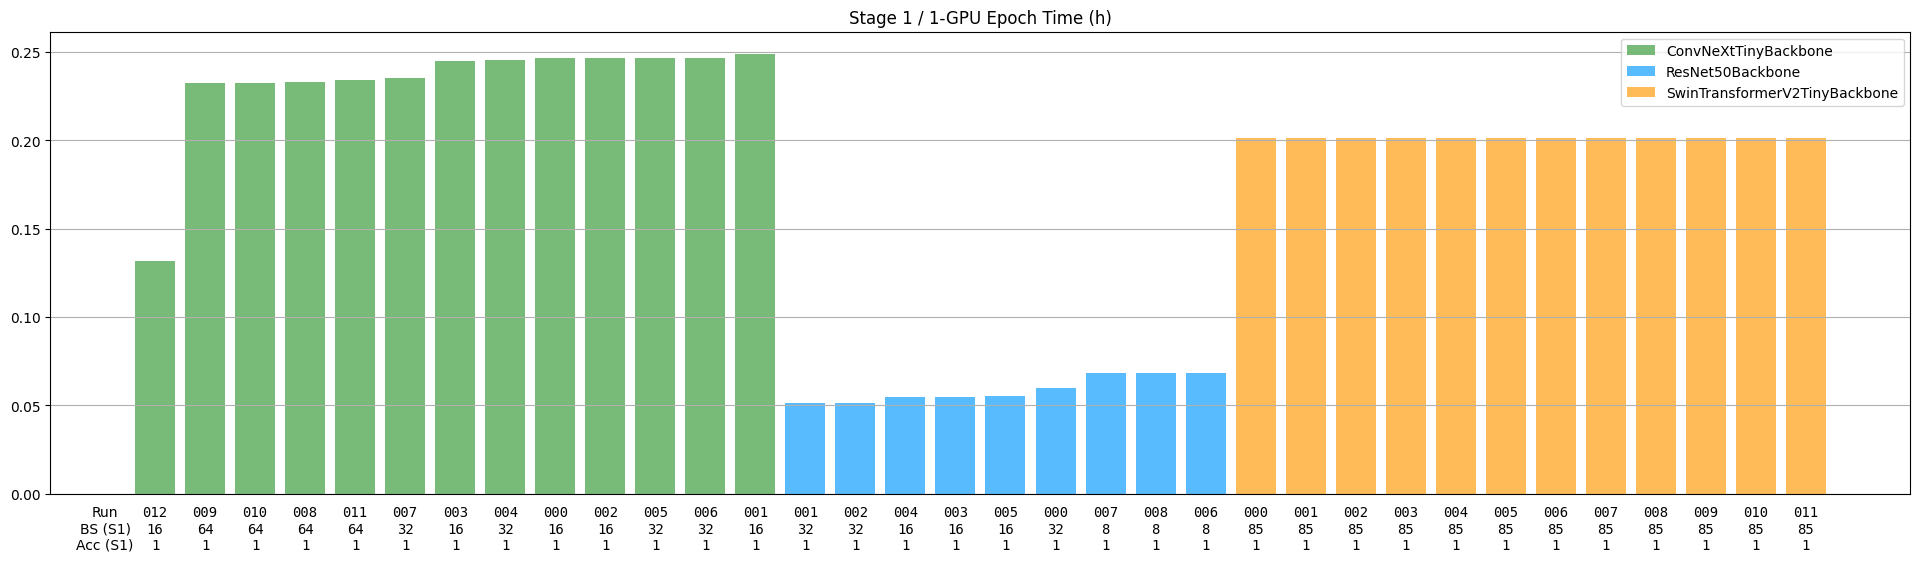

In [41]:
ord_df = df.copy()
ord_df = ord_df.sort_values(["backbone", "stage_1_mean_epoch_time"])
ord_df = ord_df.reset_index()

###

plt.figure(figsize=(24, 6))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "SwinTransformerV2TinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["stage_1_mean_epoch_time"] / 3600, width=bar_width, color=backbone_color, alpha=0.66, label=backbone)

plt.legend()

###

plt.xticks([])
plt.title("Stage 1 / 1-GPU Epoch Time (h)")

###

text_height = - plt.ylim()[1] * 0.120

text = "{:s}\n{:s}\n{:s}".format(
    "Run",
    "BS (S1)",
    "Acc (S1)"
)
plt.text(-1, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:03d}\n{:d}\n{:d}".format(
            int(ord_df_filt.at[idx, "experiment_name"][5:]),
            ord_df_filt.at[idx, "stage_1_batch_size"],
            ord_df_filt.at[idx, "stage_1_grad_acc_iters"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.grid()
plt.show()

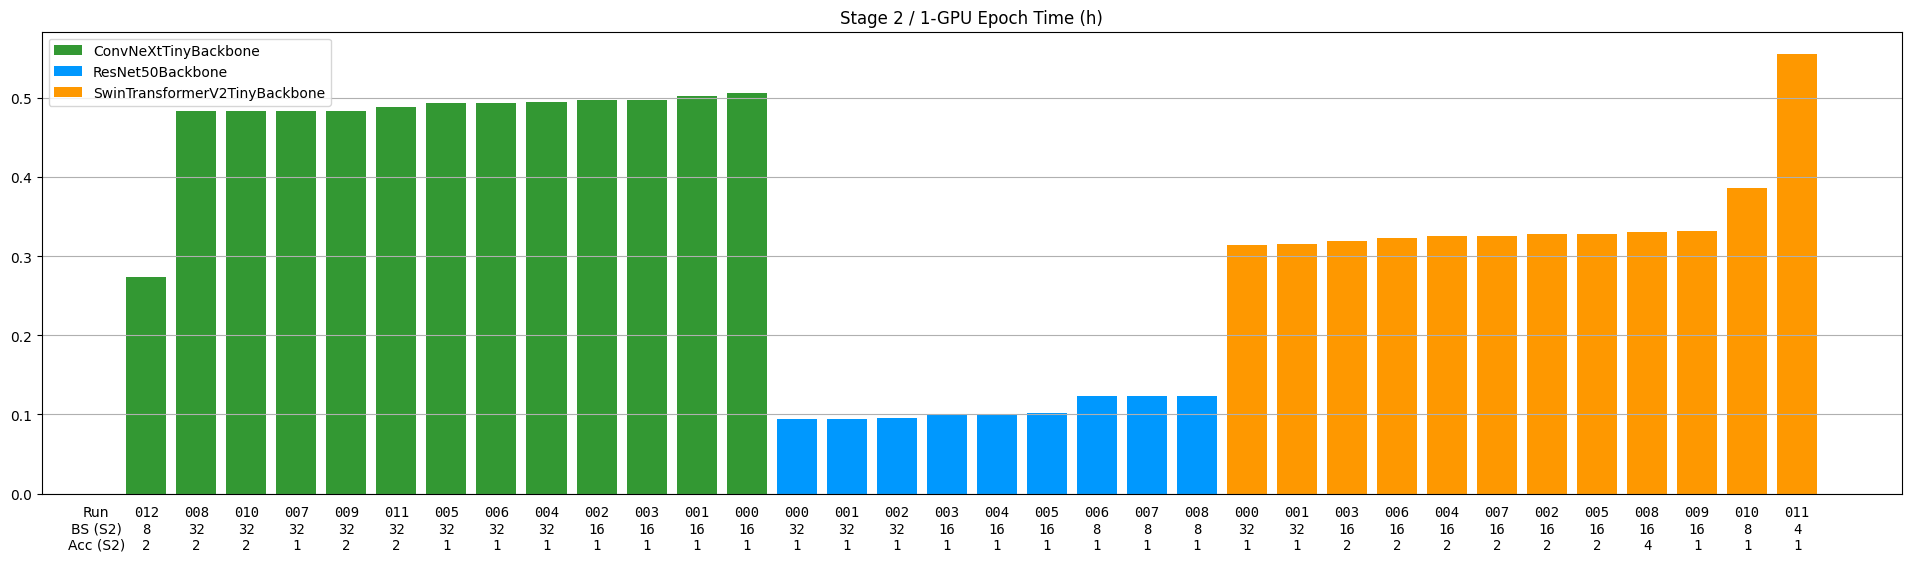

In [42]:
ord_df = df.copy()
ord_df = ord_df.sort_values(["backbone", "stage_2_mean_epoch_time"])
ord_df = ord_df.reset_index()

###

plt.figure(figsize=(24, 6))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "SwinTransformerV2TinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["stage_2_mean_epoch_time"] / 3600, width=bar_width, color=backbone_color, alpha=1, label=backbone)

plt.legend()

###

plt.xticks([])
plt.title("Stage 2 / 1-GPU Epoch Time (h)")

###

text_height = - plt.ylim()[1] * 0.120

text = "{:s}\n{:s}\n{:s}".format(
    "Run",
    "BS (S2)",
    "Acc (S2)"
)
plt.text(-1, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:03d}\n{:d}\n{:d}".format(
            int(ord_df_filt.at[idx, "experiment_name"][5:]),
            ord_df_filt.at[idx, "stage_2_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.grid()
plt.show()

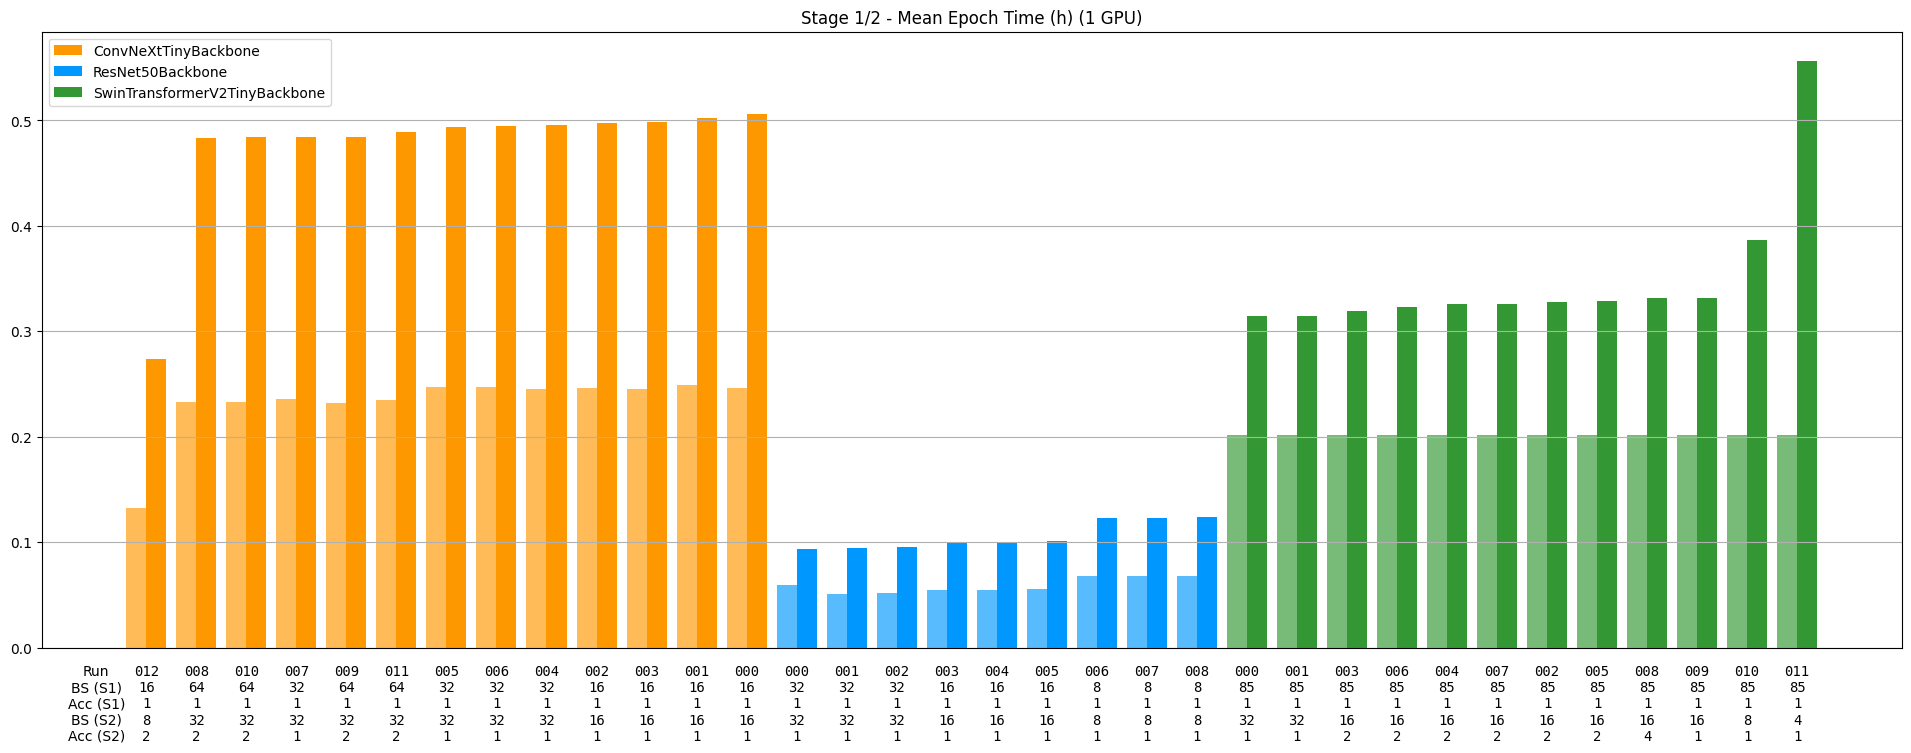

In [28]:
ord_df = df.copy()
ord_df = ord_df.sort_values(["backbone", "stage_2_mean_epoch_time"])
ord_df = ord_df.reset_index()

###

plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])
    if backbone == "SwinTransformerV2TinyBackbone": backbone_color = np.asarray([51/256, 153/256, 51/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/4, ord_df_filt["stage_1_mean_epoch_time"] / 3600, width=bar_width/2, color=backbone_color, alpha=0.66)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/4, ord_df_filt["stage_2_mean_epoch_time"] / 3600, width=bar_width/2, color=backbone_color, alpha=1, label=backbone)

plt.legend()

###

plt.xticks([])
plt.title("Stage 1/2 - Mean Epoch Time (h) (1 GPU)")

###

text_height = - plt.ylim()[1] * 0.150

text = "{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Run",
    "BS (S1)",
    "Acc (S1)",
    "BS (S2)",
    "Acc (S2)"
)
plt.text(-1, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:03d}\n{:d}\n{:d}\n{:d}\n{:d}".format(
            int(ord_df_filt.at[idx, "experiment_name"][5:]),
            ord_df_filt.at[idx, "stage_1_batch_size"],
            ord_df_filt.at[idx, "stage_1_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_2_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.grid()
plt.show()

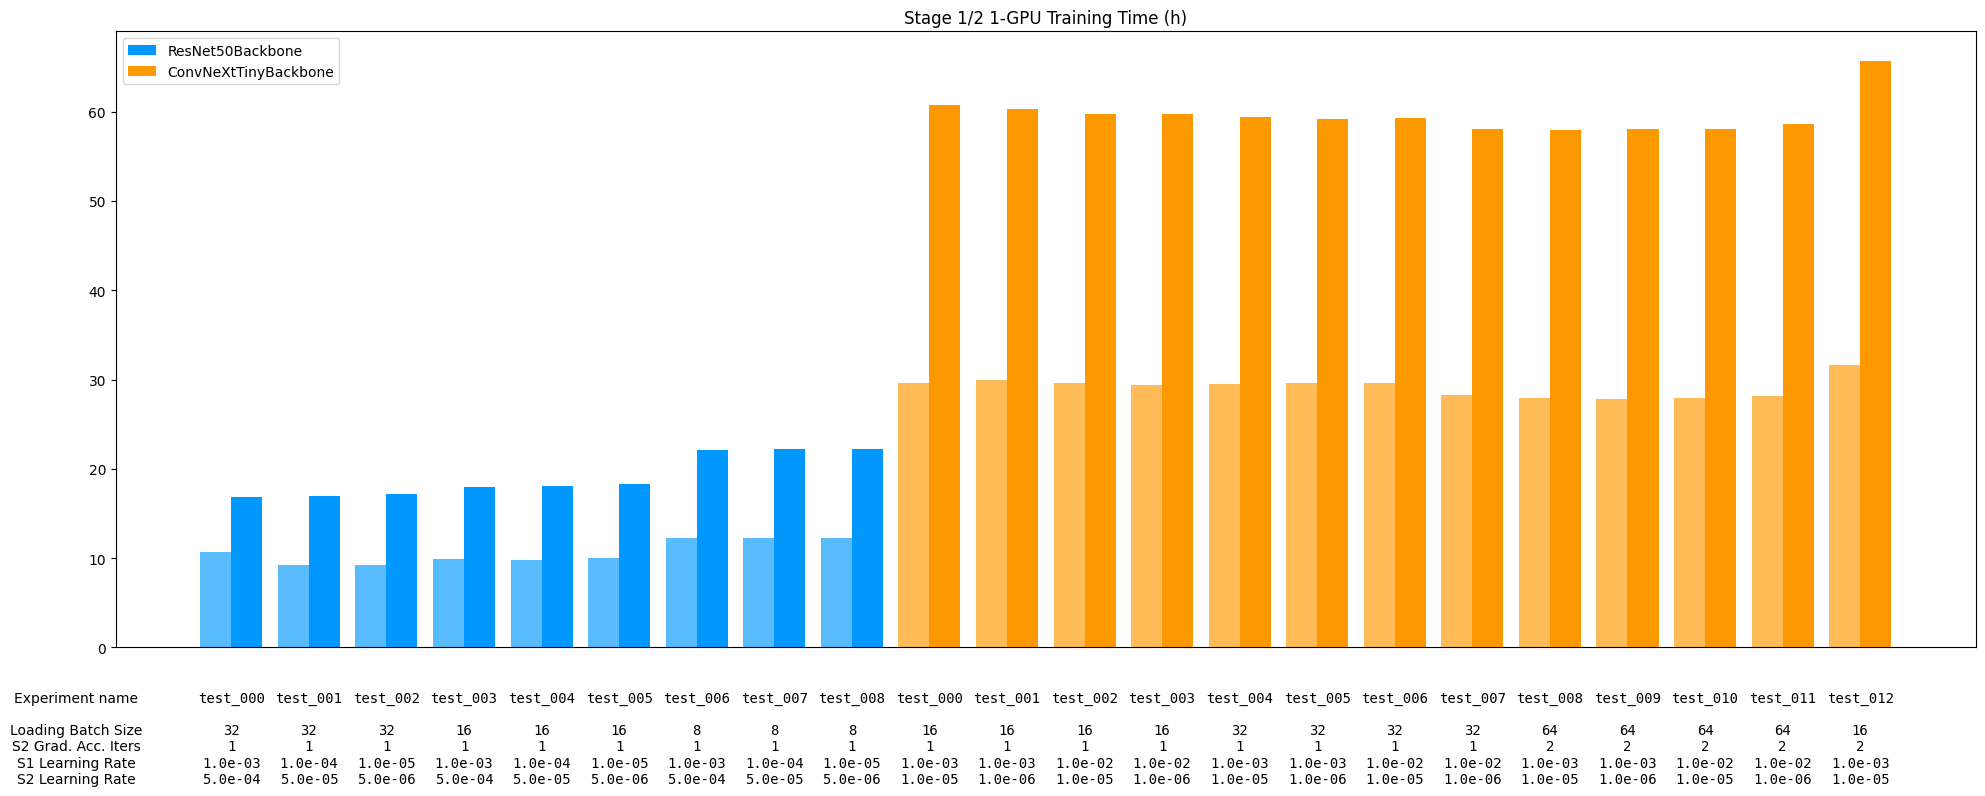

In [9]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])
    if backbone == "SwinTransformerV2Tiny": backbone_color = np.asarray([51/256, 153/256, 51/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/4, ord_df_filt["stage_1_total_epoch_time_corr"] / 3600, width=bar_width/2, color=backbone_color, alpha=0.66)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/4, ord_df_filt["stage_2_total_epoch_time_corr"] / 3600, width=bar_width/2, color=backbone_color, label=backbone)

plt.legend()

###

plt.xticks([])
plt.title("Stage 1/2 1-GPU Training Time (h)")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Loading Batch Size",
    "S2 Grad. Acc. Iters",
    "S1 Learning Rate",
    "S2 Learning Rate"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:d}\n{:d}\n{:.1e}\n{:.1e}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "loading_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_1_lr"],
            ord_df_filt.at[idx, "stage_2_lr"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")

###

plt.show()

ResNet50Backbone
267:32:13.981
ConvNeXtTinyBackbone
1154:03:18.686
Total
1421:35:32.667


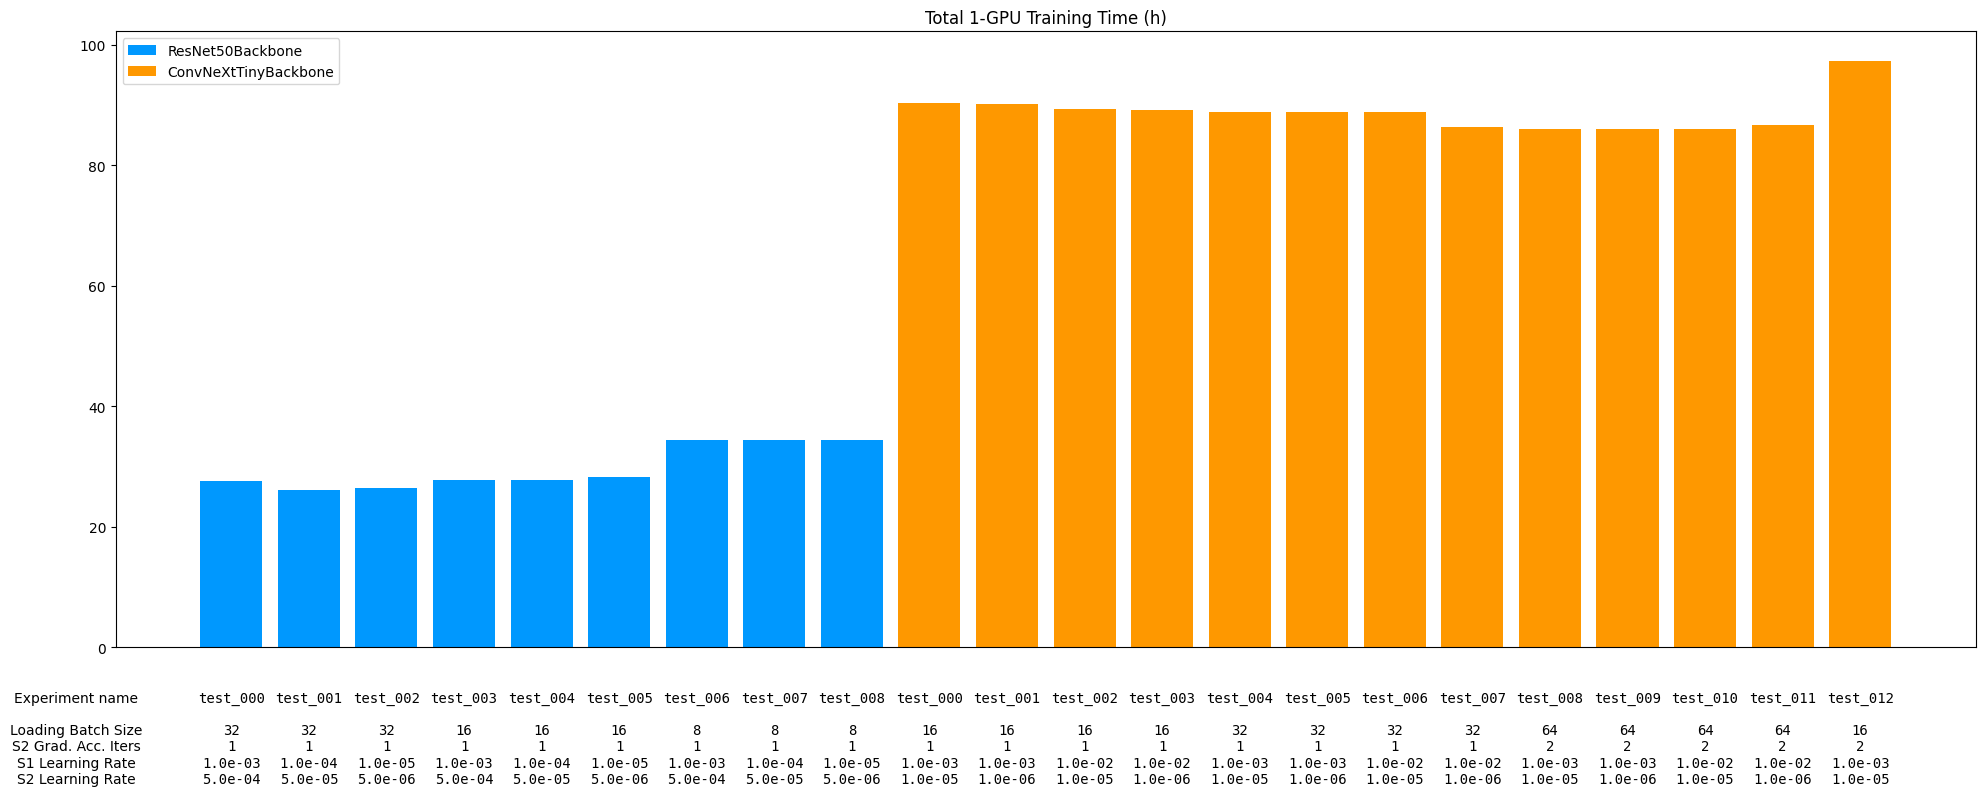

In [10]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

total = 0

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    print(backbone)
    print(utils.time.sprint_fancy_time_diff(ord_df_filt["training_time_corr"].sum()))
    
    total += ord_df_filt["training_time_corr"].sum()

    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["training_time_corr"] / 3600, width=bar_width, color=backbone_color, label=backbone)

print("Total")
print(utils.time.sprint_fancy_time_diff(total))

plt.legend()

###

plt.xticks([])
plt.title("Total 1-GPU Training Time (h)")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Loading Batch Size",
    "S2 Grad. Acc. Iters",
    "S1 Learning Rate",
    "S2 Learning Rate"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:d}\n{:d}\n{:.1e}\n{:.1e}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "loading_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_1_lr"],
            ord_df_filt.at[idx, "stage_2_lr"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")

plt.show()

In [ ]:
print("\\begin{tabular}{l", end="")
for _ in range(len(ord_df)):
    print("c", end="")
print("}", end="")
print()

###

print("Batch Size", end="")
for batch_size in ord_df["loading_batch_size"]:
    print(" & {:d}".format(batch_size), end="")
print(" \\\\")

###

print("Grad Accum. Iters", end="")
for stage_1_grad_acc_iters, stage_2_grad_acc_iters in zip(ord_df["stage_1_grad_acc_iters"], ord_df["stage_2_grad_acc_iters"]):
    print(" & {:d}".format(stage_2_grad_acc_iters), end="")
print(" \\\\")

###

print("Learning Rate (S1)", end="")
for stage_1_lr in ord_df["stage_1_lr"]:
    print(" & {:.1e}".format(float(stage_1_lr)), end="")
print(" \\\\")

###

print("Learning Rate (S2)", end="")
for stage_2_lr in ord_df["stage_2_lr"]:
    print(" & {:.1e}".format(float(stage_2_lr)), end="")
print(" \\\\")

###

print("Number of GPUs", end="")
for num_gpus in ord_df["num_gpus"]:
    print(" & {:d}".format(num_gpus), end="")